In [16]:
%matplotlib inline
import math as m
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from SAMPEX_functions import read_counts as read
from SAMPEX_functions import mb_finder, read_days, mb_magnitude, iso_calculator, OrbAtt_augment
import pandas as pd
import os
import pathlib
import string
import datetime

In [29]:
# defining file
year = '1993'
start_day = '093'
num_days = 7
month = (datetime.datetime(int(year), 1, 1) + datetime.timedelta(int(start_day)-1)).month
day = (datetime.datetime(int(year), 1, 1) + datetime.timedelta(int(start_day)-1)).day
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [30]:
# set end_day
if int(start_day[1]) < 9 or int(start_day[2]) < 4:
    if start_day[0] != '0':
        end_day = str(int(start_day) + (num_days-1))
    elif start_day[0] == '0' and start_day[1] != '0':
        end_day = '0' + str(int(start_day) + (num_days-1))
    elif start_day[0] == '0' and start_Day[1] == '0':
        end_day = '00' + str(int(start_day) + (num_days-1))
elif int(start_day[1]) >= 9 or int(start_day[2]) >= 4:
    end_day = str(int(start_day) + (num_days-1))

In [31]:
# reading in electron counts files:
t, r1, r2, r3, r4 = read_days(year, start_day, num_days, month)

In [32]:
# find microburst times and N_100, SSD1, SSD4 counts using algorithm
t_microburst, N_100_microburst, r1_microburst, r4_microburst, mb_index, MB_mask, N_100, A_500 = mb_finder(t, r1, r2, r3, r4)

In [33]:
BG_mask = ~MB_mask
# calculation of the isotropy indices of electron counts
iso_indices_MB = iso_calculator(r1[MB_mask], r4[MB_mask])
iso_indices_BG = iso_calculator(r1[BG_mask], r4[BG_mask])

In [34]:
# reading in orbit/attitude data file
directory = 'E:\SAMPEX_Data\\'
OA_file = 'OrbAtt_' + year + start_day + '-' + year + end_day + '.txt'
OrbAtt_data = pd.read_csv(directory + OA_file, names = ['sec_of_day', 'GEO_Radius', 'GEO_Long', 'GEO_Lat', 'Altitude', 'L_Shell', 'MLT', 
                                         'SAA_Flag', 'Pitch', 'zenith', 'azimuth', 'Att_Flag'], sep = '\s+', header = 70)

t_OrbAtt, LS_OrbAtt, MLT_OrbAtt, P_OrbAtt, Lat_OrbAtt, Long_OrbAtt, R_OrbAtt = OrbAtt_augment(t, OrbAtt_data, num_days)

t_OrbAtt_mb = t_OrbAtt[mb_index]; LS_OrbAtt_mb = LS_OrbAtt[mb_index]; MLT_OrbAtt_mb = MLT_OrbAtt[mb_index];
P_OrbAtt_mb = P_OrbAtt[mb_index]; Lat_OrbAtt_mb = Lat_OrbAtt[mb_index]; Long_OrbAtt_mb = Long_OrbAtt[mb_index];
R_OrbAtt_mb = R_OrbAtt[mb_index]

In [35]:
# mask out Pitch Angles and L-Shells
mask1 = (np.abs(90 - P_OrbAtt_mb) >= 50) & (LS_OrbAtt_mb >= 3) & (LS_OrbAtt_mb <= 8)
mask2 = (np.abs(90 - P_OrbAtt[BG_mask]) >= 50) & (LS_OrbAtt[BG_mask] >= 3) & (LS_OrbAtt[BG_mask] <= 8)

iso_indices_MB_masked = iso_indices_MB[mask1]
iso_indices_BG_masked = iso_indices_BG[mask2]

In [36]:
# calculating hr bin iso average for MB and BG counts
bin_size = 12               # in hours
interval = 24*num_days/2     # in hours
t_per_binsize = np.arange(0, interval*3600, bin_size*3600)

# background t
t_BG = t[BG_mask]

# create iso avg arrays
MB_iso_per_binsize = np.array([])
BG_iso_per_binsize = np.array([])
r1_per_binsize = np.array([])
r4_per_binsize = np.array([])

for i in np.arange(len(t_per_binsize)):
    if i == len(t_per_binsize)-1:  #handles end condition
        MB_iso_per_binsize = np.append(MB_iso_per_binsize, np.nanmean(iso_indices_MB_masked[(t_microburst[mask1] >= t_per_binsize[i]) & (t_microburst[mask1] < np.max(t))]))
        BG_iso_per_binsize = np.append(BG_iso_per_binsize, np.nanmean(iso_indices_BG_masked[(t_BG[mask2] >= t_per_binsize[i]) & (t_BG[mask2] < np.max(t))]))
        r1_per_binsize = np.append(r1_per_binsize, np.mean(r1[(t >= t_per_binsize[i]) & (t < np.max(t))]))
        r4_per_binsize = np.append(r4_per_binsize, np.mean(r4[(t >= t_per_binsize[i]) & (t < np.max(t))]))        
        break
    MB_iso_per_binsize = np.append(MB_iso_per_binsize, np.nanmean(iso_indices_MB_masked[(t_microburst[mask1] >= t_per_binsize[i]) & (t_microburst[mask1] < t_per_binsize[i+1])]))
    BG_iso_per_binsize = np.append(BG_iso_per_binsize, np.nanmean(iso_indices_BG_masked[(t_BG[mask2] >= t_per_binsize[i]) & (t_BG[mask2] < t_per_binsize[i+1])]))
    r1_per_binsize = np.append(r1_per_binsize, np.mean(r1[(t >= t_per_binsize[i]) & (t < t_per_binsize[i+1])]))
    r4_per_binsize = np.append(r4_per_binsize, np.mean(r4[(t >= t_per_binsize[i]) & (t < t_per_binsize[i+1])]))

<ipython-input-36-09f4e4bd65c8>:22: RuntimeWarning: Mean of empty slice
  MB_iso_per_binsize = np.append(MB_iso_per_binsize, np.nanmean(iso_indices_MB_masked[(t_microburst[mask1] >= t_per_binsize[i]) & (t_microburst[mask1] < t_per_binsize[i+1])]))


In [37]:
# define pic_directory
# at home
pic_directory = 'C:\\Users\\jacob\\Documents\\CU_Boulder\\Research\\LASP\\lasp-research\\sampexlib\\GMS Catalog\\' + year + '\\' + year + start_day + '-' + year + end_day + '\\'

# at lasp
#pic_directory = 'C:\\Users\\come6994\\Documents\\lasp-research\\sampexlib\\GMS Catalog\\' + year + '\\' + year + start_day + '-' + year + end_day + '\\'

# create new folder if it does not exist
if os.path.isdir(pic_directory) == False:
    os.mkdir(pic_directory)

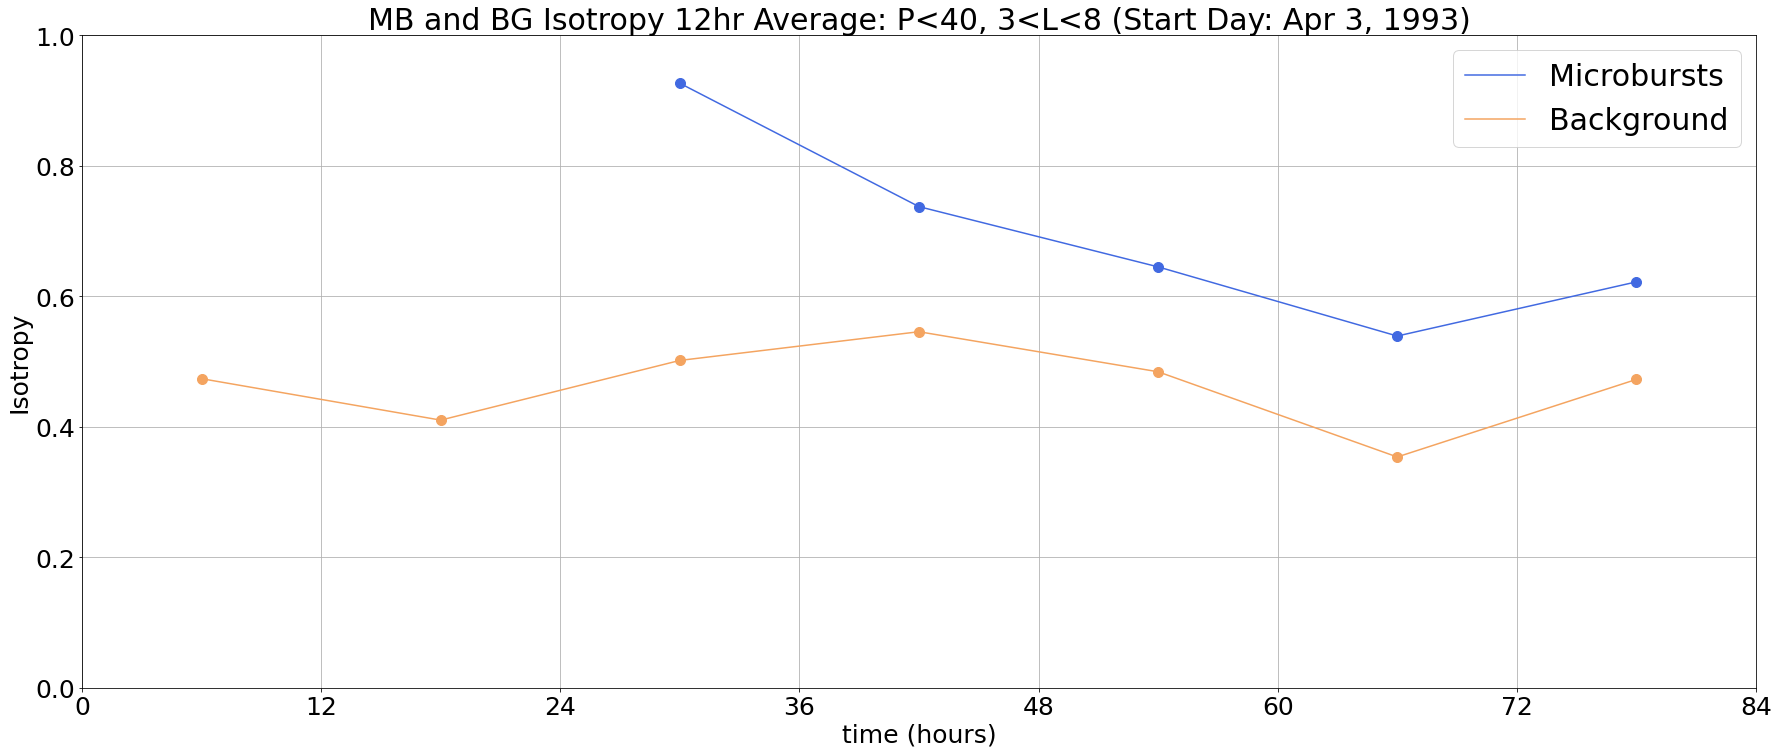

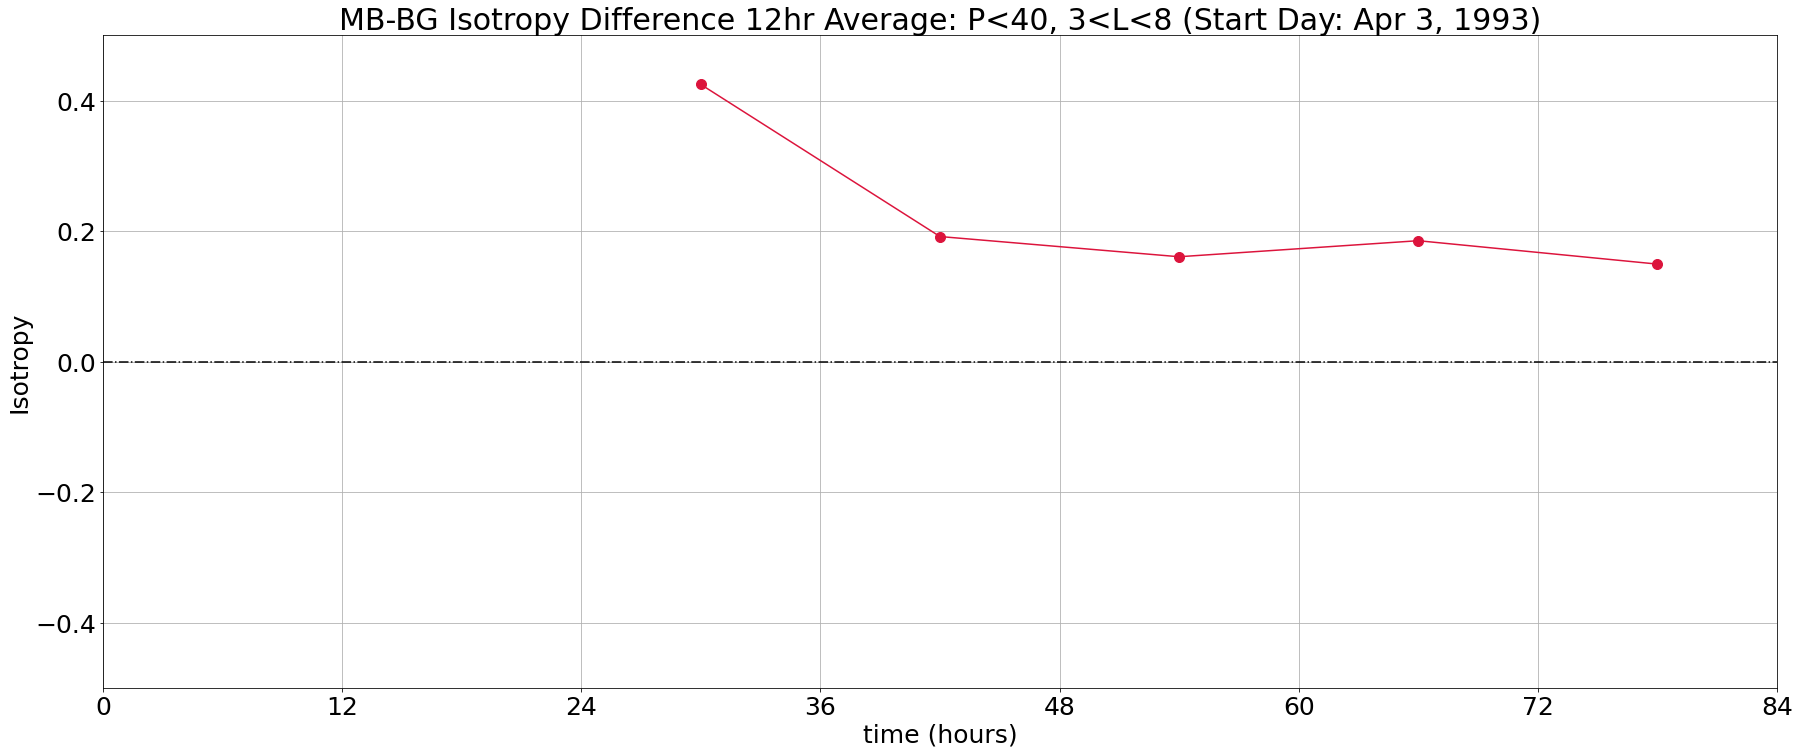

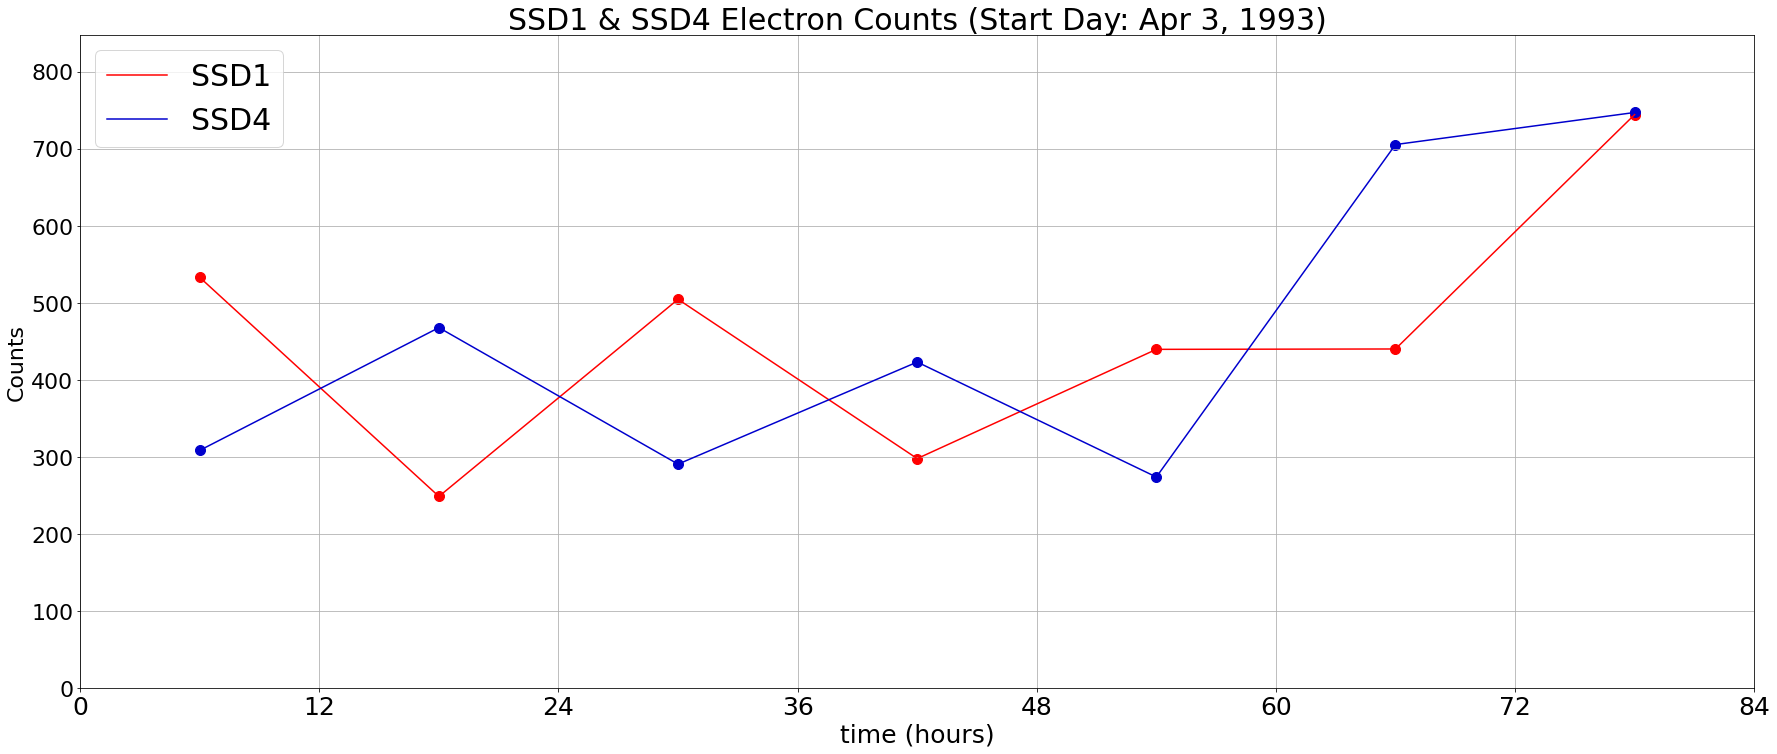

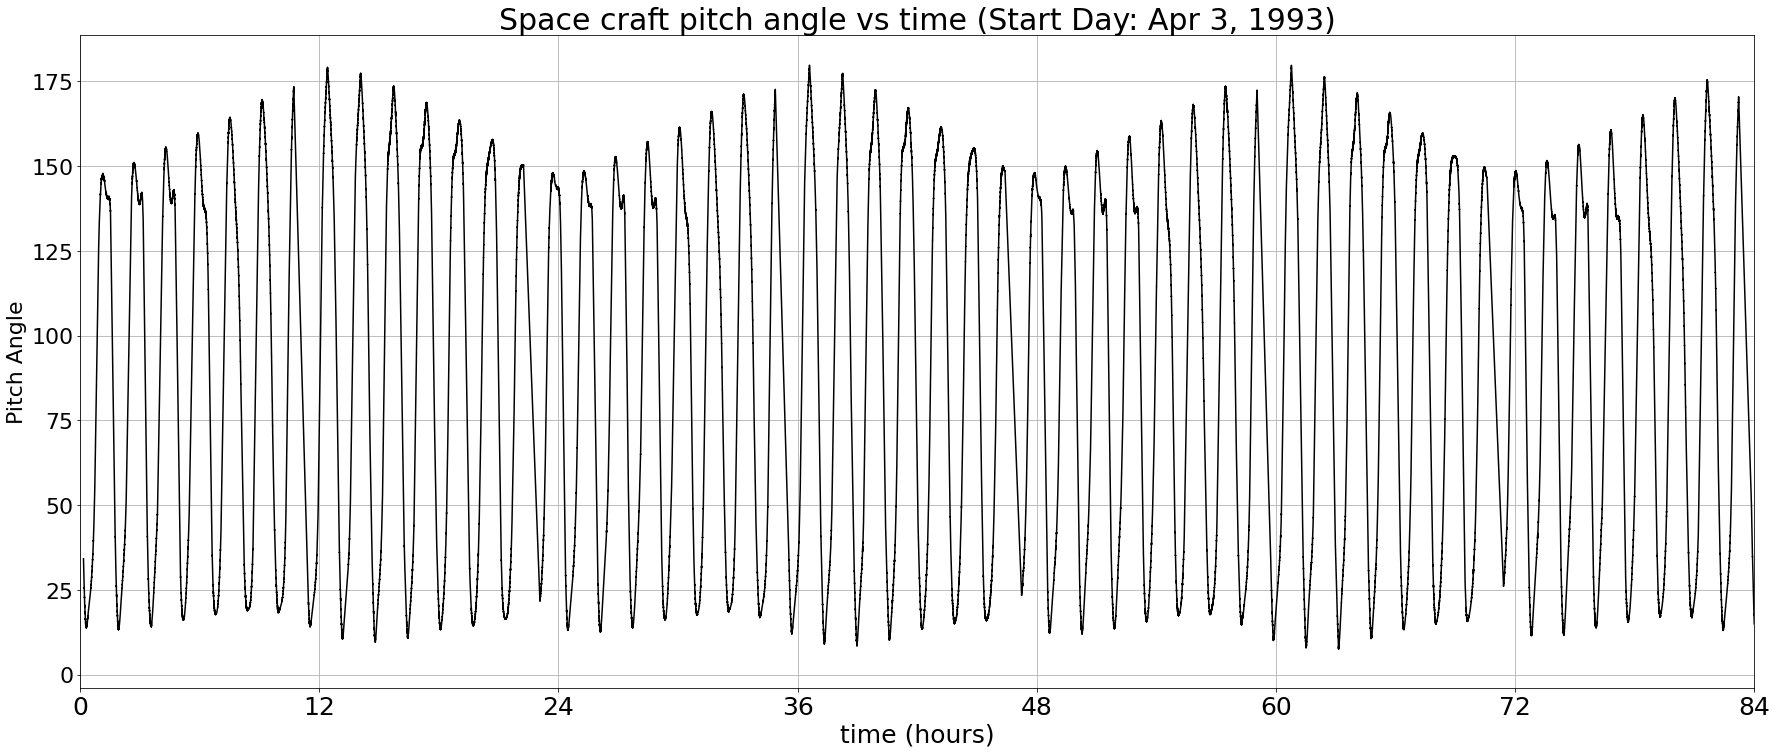

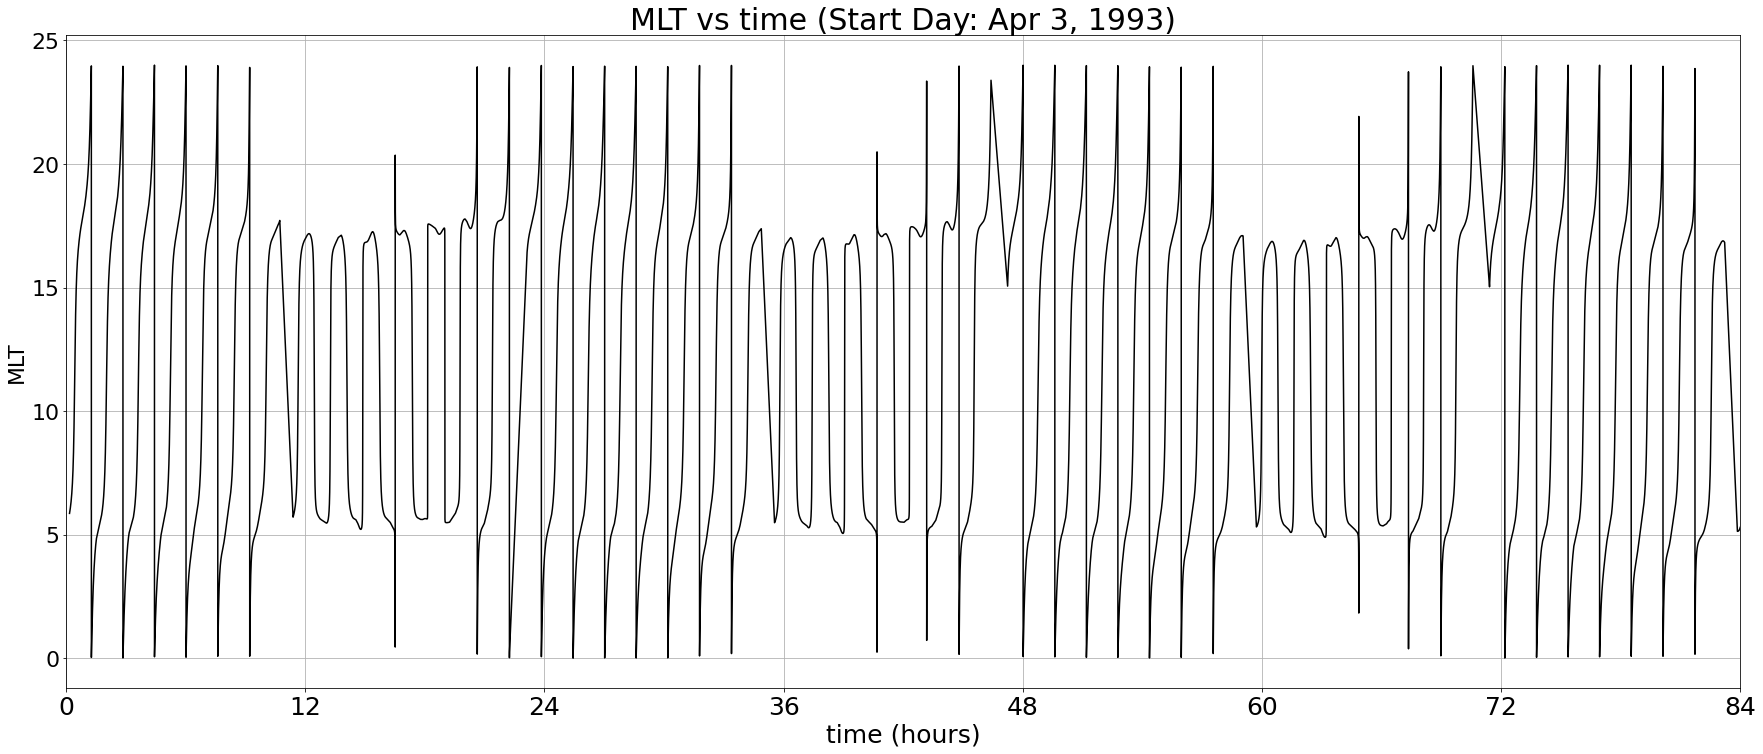

In [38]:
iso_diff = MB_iso_per_binsize - BG_iso_per_binsize
iso_ratio = MB_iso_per_binsize / BG_iso_per_binsize

# mb vs bg isotropy
plt.figure(figsize = (30,12))
plt.title(f'MB and BG Isotropy {bin_size}hr Average: P<40, 3<L<8 (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 30)
plt.plot(t_per_binsize/3600+bin_size/2, MB_iso_per_binsize, color='royalblue')
plt.plot(t_per_binsize/3600+bin_size/2, BG_iso_per_binsize, color='sandybrown')
plt.scatter(t_per_binsize/3600+bin_size/2, MB_iso_per_binsize, s=100, c='royalblue')
plt.scatter(t_per_binsize/3600+bin_size/2, BG_iso_per_binsize, s=100, c='sandybrown')
plt.xlim(0,interval)
plt.ylim(0,1)
plt.xticks(np.arange(0, interval+12, 12), fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('time (hours)', fontsize = 25)
plt.ylabel('Isotropy', fontsize = 25)
plt.legend(['Microbursts', 'Background'], fontsize = 30)
plt.grid(True)
plt.savefig(pic_directory + 'MB&BG_Iso_vs_Time_' + str(bin_size) + 'hr-avg_' + year + start_day + '-' + year + end_day + '.png')
plt.show()

# mb-bg isotropy difference vs time
plt.figure(figsize = (30,12))
plt.title(f'MB-BG Isotropy Difference {bin_size}hr Average: P<40, 3<L<8 (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 30)
plt.plot([0,interval], [0,0], color='k', linestyle='-.')
plt.plot(t_per_binsize/3600+bin_size/2, iso_diff, color='crimson')
plt.scatter(t_per_binsize/3600+bin_size/2, iso_diff, s=100, c='crimson')
plt.xlim(0,interval)
plt.ylim(-0.5, 0.5)
plt.xticks(np.arange(0, interval+12, 12), fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('time (hours)', fontsize = 25)
plt.ylabel('Isotropy', fontsize = 25)
plt.grid(True)
plt.savefig(pic_directory + 'MB&BG_IsoDiff_vs_Time_' + str(bin_size) + 'hr-avg_' + year + start_day + '-' + year + end_day + '.png')
plt.show()

# counts plot
plt.figure(figsize = (30,12))
plt.plot(t_per_binsize/3600+bin_size/2, r1_per_binsize, color='red')
plt.plot(t_per_binsize/3600+bin_size/2, r4_per_binsize, color='MediumBlue')
plt.scatter(t_per_binsize/3600+bin_size/2, r1_per_binsize, s=100, c='red')
plt.scatter(t_per_binsize/3600+bin_size/2, r4_per_binsize, s=100, c='MediumBlue')
plt.title(f'SSD1 & SSD4 Electron Counts (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 30)
plt.xlabel('time (hours)', fontsize = 25)
plt.ylabel('Counts', fontsize = 22)
plt.xlim(0,interval)
plt.ylim(0,np.max(np.append(r1_per_binsize, r4_per_binsize))+100)
plt.xticks(np.arange(0, interval+12, 12), fontsize = 25)
plt.yticks(fontsize = 22)
plt.legend(['SSD1', 'SSD4'], fontsize = 30)
plt.grid(True)
plt.savefig(pic_directory + 'SSD1&4_Counts_' + str(bin_size) + 'hr-avg_' + year + start_day + '-' + year + end_day + '.png')
plt.show()

# pitch angle vs time
plt.figure(figsize = (30,12))
plt.plot(t_OrbAtt/3600, P_OrbAtt, color='k')
plt.title(f'Space craft pitch angle vs time (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 30)
plt.xlabel('time (hours)', fontsize = 25)
plt.ylabel('Pitch Angle', fontsize = 22)
plt.xlim(0,interval)
plt.xticks(np.arange(0, interval+12, 12), fontsize = 25)
plt.yticks(fontsize = 22)
plt.grid(True)
plt.show()

# mlt vs time
plt.figure(figsize = (30,12))
plt.plot(t_OrbAtt/3600, MLT_OrbAtt, color='k')
plt.title(f'MLT vs time (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 30)
plt.xlabel('time (hours)', fontsize = 25)
plt.ylabel('MLT', fontsize = 22)
plt.xlim(0,interval)
plt.xticks(np.arange(0, interval+12, 12), fontsize = 25)
plt.yticks(fontsize = 22)
plt.grid(True)
plt.show()

In [64]:
# calculating MLT bin iso average for MB and BG counts
bin_size = 1
interval = 24
MLT_per_binsize = np.arange(0, interval, bin_size)

# create iso avg arrays
MB_iso_per_binsize = np.array([])
BG_iso_per_binsize = np.array([])
r1_per_binsize = np.array([])
r4_per_binsize = np.array([])

MLT_OrbAtt_bg = MLT_OrbAtt[BG_mask]

for i in np.arange(len(MLT_per_binsize)):
    if i == len(MLT_per_binsize)-1:  #handles end condition
        MB_iso_per_binsize = np.append(MB_iso_per_binsize, np.nanmean(iso_indices_MB_masked[(MLT_OrbAtt_mb[mask1] >= MLT_per_binsize[i]) & (MLT_OrbAtt_mb[mask1] < np.max(MLT_OrbAtt))]))
        BG_iso_per_binsize = np.append(BG_iso_per_binsize, np.nanmean(iso_indices_BG_masked[(MLT_OrbAtt_bg[mask2] >= MLT_per_binsize[i]) & (MLT_OrbAtt_bg[mask2] < np.max(MLT_OrbAtt))]))
        r1_per_binsize = np.append(r1_per_binsize, np.mean(r1[(MLT_OrbAtt >= MLT_per_binsize[i]) & (MLT_OrbAtt < np.max(MLT_OrbAtt))]))
        r4_per_binsize = np.append(r4_per_binsize, np.mean(r4[(MLT_OrbAtt >= MLT_per_binsize[i]) & (MLT_OrbAtt < np.max(MLT_OrbAtt))]))        
        break
    MB_iso_per_binsize = np.append(MB_iso_per_binsize, np.nanmean(iso_indices_MB_masked[(MLT_OrbAtt_mb[mask1] >= MLT_per_binsize[i]) & (MLT_OrbAtt_mb[mask1] < MLT_per_binsize[i+1])]))
    BG_iso_per_binsize = np.append(BG_iso_per_binsize, np.nanmean(iso_indices_BG_masked[(MLT_OrbAtt_bg[mask2] >= MLT_per_binsize[i]) & (MLT_OrbAtt_bg[mask2] < MLT_per_binsize[i+1])]))
    r1_per_binsize = np.append(r1_per_binsize, np.mean(r1[(MLT_OrbAtt >= MLT_per_binsize[i]) & (MLT_OrbAtt < MLT_per_binsize[i+1])]))
    r4_per_binsize = np.append(r4_per_binsize, np.mean(r4[(MLT_OrbAtt >= MLT_per_binsize[i]) & (MLT_OrbAtt < MLT_per_binsize[i+1])]))

<ipython-input-64-929daa77cc09>:21: RuntimeWarning: Mean of empty slice
  MB_iso_per_binsize = np.append(MB_iso_per_binsize, np.nanmean(iso_indices_MB_masked[(MLT_OrbAtt_mb[mask1] >= MLT_per_binsize[i]) & (MLT_OrbAtt_mb[mask1] < MLT_per_binsize[i+1])]))
<ipython-input-64-929daa77cc09>:22: RuntimeWarning: Mean of empty slice
  BG_iso_per_binsize = np.append(BG_iso_per_binsize, np.nanmean(iso_indices_BG_masked[(MLT_OrbAtt_bg[mask2] >= MLT_per_binsize[i]) & (MLT_OrbAtt_bg[mask2] < MLT_per_binsize[i+1])]))


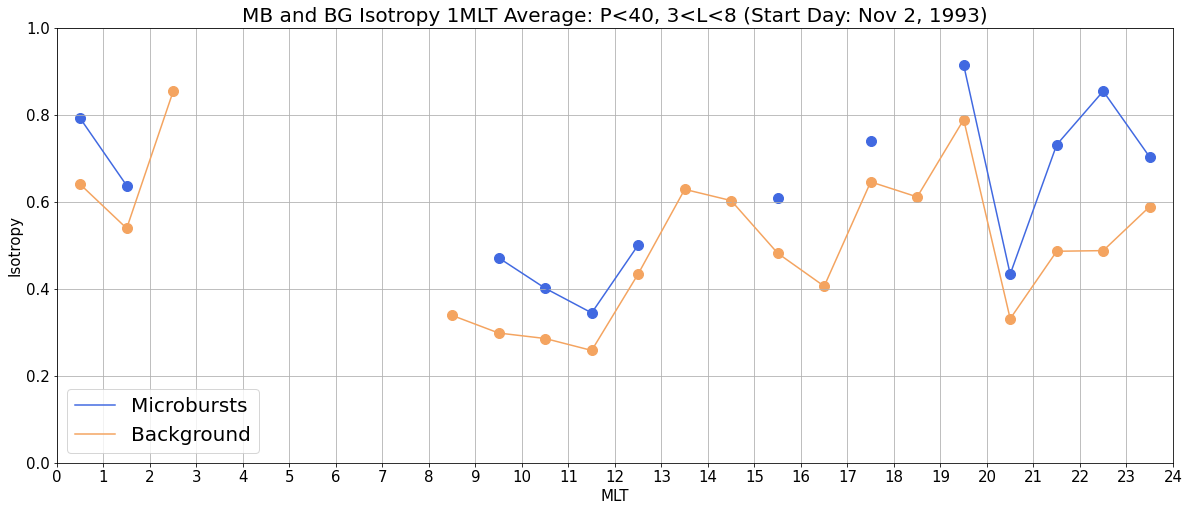

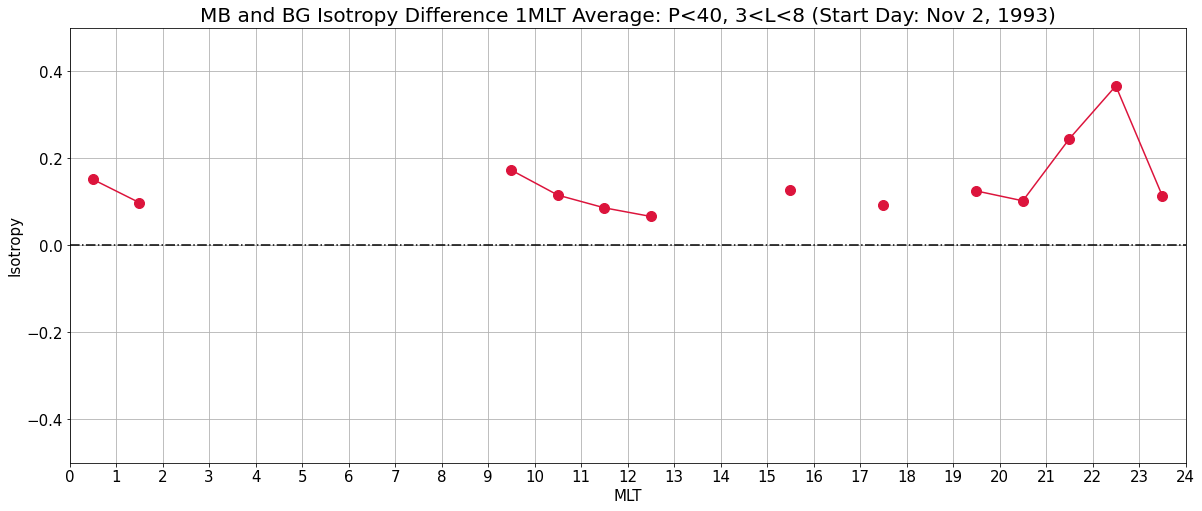

In [65]:
# mb vs bg isotropy
plt.figure(figsize = (20,8))
plt.title(f'MB and BG Isotropy {bin_size}MLT Average: P<40, 3<L<8 (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 20)
plt.plot(MLT_per_binsize+bin_size/2, MB_iso_per_binsize, color='royalblue')
plt.plot(MLT_per_binsize+bin_size/2, BG_iso_per_binsize, color='sandybrown')
plt.scatter(MLT_per_binsize+bin_size/2, MB_iso_per_binsize, s=100, c='royalblue')
plt.scatter(MLT_per_binsize+bin_size/2, BG_iso_per_binsize, s=100, c='sandybrown')
plt.xlim(0,interval)
plt.ylim(0,1)
plt.xticks(np.arange(0, interval+bin_size, bin_size), fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('MLT', fontsize = 15)
plt.ylabel('Isotropy', fontsize = 15)
plt.legend(['Microbursts', 'Background'], fontsize = 20)
plt.grid(True)
plt.savefig(pic_directory + 'MB&BG_Iso_vs_MLT_' + year + start_day + '-' + year + end_day + '.png')
plt.show()

# mb/bg isotropy diff
# calculate difference
iso_diff = MB_iso_per_binsize - BG_iso_per_binsize

# plot diff
plt.figure(figsize = (20,8))
plt.title(f'MB and BG Isotropy Difference {bin_size}MLT Average: P<40, 3<L<8 (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 20)
plt.plot(MLT_per_binsize+bin_size/2, iso_diff, color='crimson')
plt.scatter(MLT_per_binsize+bin_size/2, iso_diff, s=100, c='crimson')
plt.plot([0,interval], [0,0], color='k', linestyle='-.')
plt.xlim(0,interval)
plt.ylim(-0.5, 0.5)
plt.xticks(np.arange(0, interval+bin_size, bin_size), fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('MLT', fontsize = 15)
plt.ylabel('Isotropy', fontsize = 15)
plt.grid(True)
plt.savefig(pic_directory + 'MB&BG_IsoDiff_vs_MLT_' + year + start_day + '-' + year + end_day + '.png')
plt.show()